# Wine quality prediction with a Dense Network (DNN)

## Objectives  :
- Predict the quality of wines, based on their analysis
- Understanting the principal and the architecture of a regression with a dense neural network with backup and restore of the trained model.

The Wine Quality datasets are made up of analyses of a large number of wines, with an associated quality (betwenn 0 and 10).
This dataset is provide by :
Paulo Cortez, University of Minho, Guimaräes, Portugal


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

2024-02-12 08:11:32.182465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Step 2 - Retrieve data

In [2]:
data = pd.read_csv('winequality-white.csv', header =0, sep=';')
display(data.head(5).style.format("{0:.2f}"))
print ('Missing Data:',data.isna().sum().sum(), ' Shape is:', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.00,0.27,0.36,20.70,0.04,45.00,170.00,1.00,3.00,0.45,8.80,6.00
1,6.30,0.30,0.34,1.60,0.05,14.00,132.00,0.99,3.30,0.49,9.50,6.00
2,8.10,0.28,0.40,6.90,0.05,30.00,97.00,1.00,3.26,0.44,10.10,6.00
3,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6.00
4,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6.00


Missing Data: 0  Shape is: (4898, 12)


# Step 3 - Preparing the data

## 3.1 - Split data

We will use 80% of the data for training and 20% for validation.
x will be the data of the analysis and y the quality.

In [3]:
# ------ split => train, test
data = data.sample(frac=1., axis=0)
data_train = data.sample(frac=0.8, axis=0)
data_test = data.drop(data_train.index)

# ------ split => x, y (y is quality)
x_train = data_train.drop('quality', axis=1)
y_train = data_train['quality']
x_test = data_test.drop('quality', axis=1)
y_test = data_test['quality']

print ('Original data shape was:', data.shape)
print ('x_train:', x_train.shape, ' y_train:', y_train.shape)
print ('x_test:', x_test.shape, ' y_test:', y_test.shape)

Original data shape was: (4898, 12)
x_train: (3918, 11)  y_train: (3918,)
x_test: (980, 11)  y_test: (980,)


## 3.2 - Data normalization

Note :

- All input data muste be normalized, train and test.
- To do this we will subtract the mean and divide by the standard deviation.
- But test data should not be used in any way, even for normalization.
- The mean and the standard deviation will therefore only be calculated with the train data.

In [4]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before Normalization : "))

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After Normalization : "))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00
mean,6.85,0.28,0.33,6.41,0.05,35.52,138.47,0.99,3.19,0.49,10.51
std,0.84,0.10,0.12,5.08,0.02,17.14,42.30,0.00,0.15,0.11,1.23
min,3.80,0.08,0.00,0.60,0.01,3.00,9.00,0.99,2.72,0.22,8.00
25%,6.30,0.21,0.27,1.70,0.04,24.00,108.00,0.99,3.08,0.41,9.50
50%,6.80,0.26,0.32,5.20,0.04,34.00,135.00,0.99,3.18,0.47,10.40
75%,7.30,0.32,0.39,10.00,0.05,46.00,167.00,1.00,3.28,0.55,11.40
max,11.80,0.96,1.66,65.80,0.30,289.00,440.00,1.04,3.81,1.00,14.20


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00
mean,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.64,-1.97,-2.73,-1.15,-1.67,-1.90,-3.06,-2.30,-3.08,-2.38,-2.04
25%,-0.66,-0.68,-0.53,-0.93,-0.45,-0.67,-0.72,-0.76,-0.71,-0.70,-0.82
50%,-0.06,-0.18,-0.12,-0.24,-0.13,-0.09,-0.08,-0.08,-0.05,-0.17,-0.09
75%,0.54,0.42,0.45,0.71,0.19,0.61,0.67,0.72,0.61,0.53,0.72
max,5.91,6.84,10.82,11.70,11.53,14.79,7.13,14.95,4.09,4.51,3.00


# Step 4 - Build a model

In [5]:
def get_model_v1(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=shape, name='InputLayer'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(tf.keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mse'])
    return model   

# Step 5 - Train the model 

## 5.1 - Get it 

In [6]:
model = get_model_v1((11,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5.2 - Add callback

In [7]:
os.makedirs('./run/models', mode=0o750, exist_ok=True)
save_dir = './run/models/best_white_model.h5'

savemodel = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

## 5.3 - Train it

In [8]:
history = model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[savemodel], verbose=0)

/Users/jules/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 6 - Evaluate

## 6.1 - Model evaluation 

MAE = Mean Absolute Error (between the labels and predictions)
A MAE equal to 3 represents an average error in prdection of $3K.

In [9]:
scrore = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f} '.format(scrore[0]))
print('x_test / mae : {:5.4f} '.format(scrore[1]))
print('x_test / mse : {:5.4f} '.format(scrore[2]))

x_test / loss : 0.5799 
x_test / mae : 0.5910 
x_test / mse : 0.5799 


## 6.2 - Training history

What was the best result during our training?

In [10]:
print("min(val_mae) : {:.4f}".format(min(history.history['val_mae'])))

min(val_mae) : 0.5300


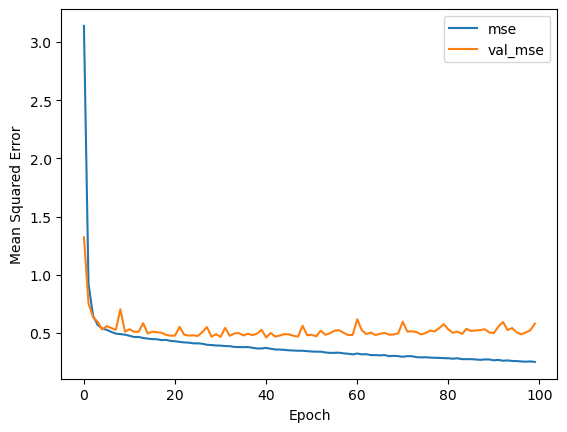

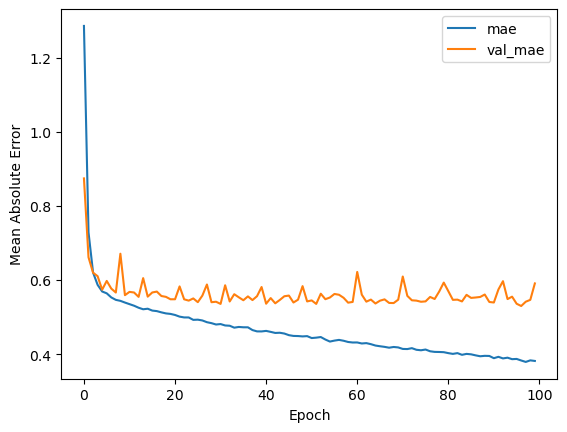

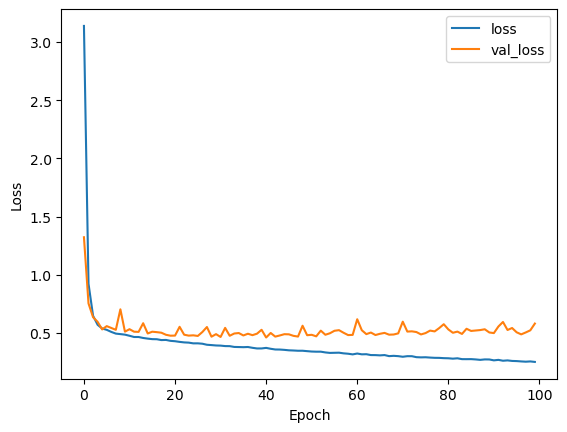

In [11]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 7 - Restore a model :

## 7.1 - Reload model

In [12]:
loaded_model = tf.keras.models.load_model('./run/models/best_white_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Loaded.


## 7.2 - Evaluate it :

In [13]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f} '.format(score[0]))
print('x_test / mae : {:5.4f} '.format(score[1]))
print('x_test / mse : {:5.4f} '.format(score[2]))

x_test / loss : 0.4602 
x_test / mae : 0.5362 
x_test / mse : 0.4602 


## 7.3 - Make a prediction

In [14]:
# ------ Pick n entries from our test set
n = 200
ii = np.random.randint(1, len(x_test), n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [15]:
# ------ Make a prediction
y_pred = loaded_model.predict(x_sample, verbose=2)

7/7 - 0s - 87ms/epoch - 12ms/step


In [16]:
# ------ Show it
print('Wine Prediction Real Delta ')
for i in range(n):
    pred = y_pred[i][0]
    real = y_sample[i]
    delta = real - pred
    print(f'{i:03d} {pred:.2f} {real} {delta:.2f}')

Wine Prediction Real Delta 
000 5.71 6 0.29
001 5.28 5 -0.28
002 5.14 5 -0.14
003 5.80 5 -0.80
004 6.13 6 -0.13
005 6.96 8 1.04
006 6.49 7 0.51
007 8.00 6 -2.00
008 7.33 7 -0.33
009 5.20 6 0.80
010 6.38 6 -0.38
011 4.97 5 0.03
012 5.27 5 -0.27
013 6.28 6 -0.28
014 5.08 5 -0.08
015 6.67 6 -0.67
016 7.29 7 -0.29
017 6.34 7 0.66
018 5.96 6 0.04
019 5.99 7 1.01
020 5.11 5 -0.11
021 5.37 5 -0.37
022 6.17 7 0.83
023 5.80 6 0.20
024 5.89 6 0.11
025 5.11 5 -0.11
026 5.93 6 0.07
027 5.98 5 -0.98
028 6.29 6 -0.29
029 5.08 5 -0.08
030 5.34 5 -0.34
031 6.07 6 -0.07
032 5.99 7 1.01
033 6.10 6 -0.10
034 5.41 5 -0.41
035 5.38 4 -1.38
036 7.09 7 -0.09
037 6.75 6 -0.75
038 6.53 7 0.47
039 6.52 7 0.48
040 5.40 7 1.60
041 6.12 6 -0.12
042 5.68 6 0.32
043 6.08 6 -0.08
044 4.92 6 1.08
045 6.04 7 0.96
046 4.94 4 -0.94
047 5.45 6 0.55
048 5.81 5 -0.81
049 5.86 5 -0.86
050 6.35 6 -0.35
051 6.23 6 -0.23
052 5.41 5 -0.41
053 6.21 7 0.79
054 5.78 5 -0.78
055 6.15 7 0.85
056 6.94 7 0.06
057 5.49 7 1.51
058 5.71 6